In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
colab=True
try:
  from google.colab import drive
except:
  colab =False
if colab :
    drive.mount('/content/drive')
    print('g-drive mounted.')
else : print('local drive.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
g-drive mounted.


In [ ]:
# Loading saved models
model1 = tf.keras.models.load_model("/content/drive/MyDrive/files/save/age-gender-mov2-1.keras", compile=True)
model2 = tf.keras.models.load_model("/content/drive/MyDrive/files/save/age-gender-mov2-2.keras", compile=True)
model3 = tf.keras.models.load_model("/content/drive/MyDrive/files/save/age-gender-mov2-3.keras", compile=True)

## (Optional) tflite 파일 생성


In [ ]:
colab=True
if colab :
  save_dir = '/content/drive/MyDrive/files/save/'
else :
  save_dir = '../files/save/'

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()
tfliteFileName = 'age-gender-mov2-1.tflite'
open(save_dir + tfliteFileName, 'wb').write(tflite_model)

converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()
tfliteFileName = 'age-gender-mov2-2.tflite'
open(save_dir + tfliteFileName, 'wb').write(tflite_model)

converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()
tfliteFileName = 'age-gender-mov2-3.tflite'
open(save_dir + tfliteFileName, 'wb').write(tflite_model)

9123596

In [ ]:
dir_path = "/content/drive/MyDrive/files/UTKFace/"
image_path = os.listdir(dir_path)
np.random.shuffle(image_path)
n_image_path = []
for path in image_path:
  try:
    age = int(path.split("_")[0])
    race = int(path.split("_")[2])
    if 10 <= age <= 65 and race == 2:
      n_image_path.append(path)
  except:
    pass
image_path = n_image_path

In [ ]:
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split
BATCH_SIZE=128
IMAGE_SIZE=224
# SHuffling the Images
np.random.shuffle(image_path)

# Split data into training, testing and validation set
train_images, test_images = train_test_split(
    image_path,
    train_size = 0.8,
    test_size = 0.2
)

print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")

NORM = 120

# def one_hot_encode(labels):
#     n_classes = 2
#     one_hot_encoded = np.eye(n_classes)[labels]
#     return one_hot_encoded

# Extract age and gender
train_ages = np.array([int(path.split("_")[0]) for path in train_images])
# train_ages = tf.cast(train_ages, tf.float32)/NORM
train_genders = np.array([int(path.split("_")[1]) for path in train_images])
# train_genders = tf.cast(one_hot_encode(train_genders), tf.float32)

test_ages = np.array([int(path.split("_")[0]) for path in test_images])
# test_ages = tf.cast(test_ages, tf.float32)/NORM
test_genders = np.array([int(path.split("_")[1]) for path in test_images])
# test_genders = tf.cast(one_hot_encode(test_genders), tf.float32)

def preprocess_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    """
    Preprocesses an image for analysis by extracting age and gender from the image path,
    loading and decoding the image, resizing it to (IMAGE_SIZE,IMAGE_SIZE), normalizing pixel values,
    and returning the preprocessed image along with age and gender labels.

    Args:
    - image_path (str): The path to the image file.
    - dir_path (str): The directory path where the image is located. Defaults to `dir_path`.

    Returns:
    - tuple: A tuple containing the preprocessed image as a TensorFlow tensor,
             the age (int), and the gender (int) extracted from the image path.
    """
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return (image, {'AgeOutput': age, 'GenderOutput': gender})

train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_single_ds = train_ds.map(preprocess_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_single_ds = test_ds.map(preprocess_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

Training Size : 1843
Testing Size  : 461


In [ ]:
from tensorflow.keras.metrics import MeanAbsoluteError, Accuracy
mae_metric = MeanAbsoluteError()
accuracy_metric = Accuracy()

mae_metric1 = MeanAbsoluteError()
accuracy_metric1 = Accuracy()
mae_metric2 = MeanAbsoluteError()
accuracy_metric2 = Accuracy()
mae_metric3 = MeanAbsoluteError()
accuracy_metric3 = Accuracy()
# 데이터셋을 반복하여 예측값을 얻고, 실제 값과 비교합니다.
for batch in test_single_ds:
    images, labels = batch
    true_ages = labels['AgeOutput']
    true_genders = labels['GenderOutput']

    # 각 모델의 예측
    pred_age1,pred_gender1 = model1(images, training=False)
    pred_age2,pred_gender2 = model2(images, training=False)
    pred_age3,pred_gender3 = model3(images, training=False)

    # 각 모델의 예측값을 평균냅니다.
    pred_ages = (pred_age1 + pred_age2 + pred_age3) / 3.0
    pred_genders = (pred_gender1 + pred_gender2 + pred_gender3) / 3.0

    # MAE 업데이트
    mae_metric.update_state(true_ages, pred_ages)
    mae_metric1.update_state(true_ages, pred_age1)
    mae_metric2.update_state(true_ages, pred_age2)
    mae_metric3.update_state(true_ages, pred_age3)
    # Gender Accuracy 업데이트
    accuracy_metric.update_state(true_genders, np.round(pred_genders,0))
    accuracy_metric1.update_state(true_genders, np.round(pred_gender1,0))
    accuracy_metric2.update_state(true_genders, np.round(pred_gender2,0))
    accuracy_metric3.update_state(true_genders, np.round(pred_gender3,0))

# 최종 MAE와 Accuracy를 계산합니다.
final_mae = mae_metric.result().numpy()
final_accuracy = accuracy_metric.result().numpy()
final_mae1 = mae_metric1.result().numpy()
final_accuracy1 = accuracy_metric1.result().numpy()
final_mae2 = mae_metric2.result().numpy()
final_accuracy2 = accuracy_metric2.result().numpy()
final_mae3 = mae_metric3.result().numpy()
final_accuracy3 = accuracy_metric3.result().numpy()

print(f"Sampled model1 Age MAE: {final_mae1:.3}")
print(f"Sampled model1 Gender Accuracy: {final_accuracy1:.3}")
print(f"Sampled model2 Age MAE: {final_mae2:.3}")
print(f"Sampled model2 Gender Accuracy: {final_accuracy2:.3}")
print(f"Sampled model3 Age MAE: {final_mae3:.3}")
print(f"Sampled model3 Gender Accuracy: {final_accuracy3:.3}")
print(f"Ensemble model Age MAE: {final_mae:.3}")
print(f"Ensemble model Gender Accuracy: {final_accuracy:.3}")

Sampled model1 Age MAE: 5.69
Sampled model1 Gender Accuracy: 0.866
Sampled model2 Age MAE: 6.26
Sampled model2 Gender Accuracy: 0.857
Sampled model3 Age MAE: 5.86
Sampled model3 Gender Accuracy: 0.861
Ensemble model Age MAE: 5.22
Ensemble model Gender Accuracy: 0.868


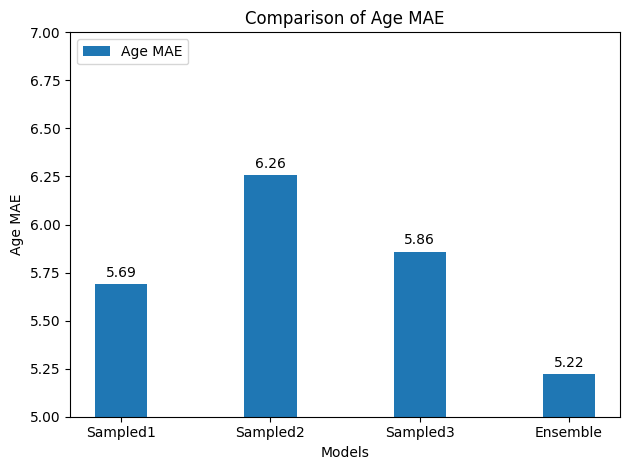

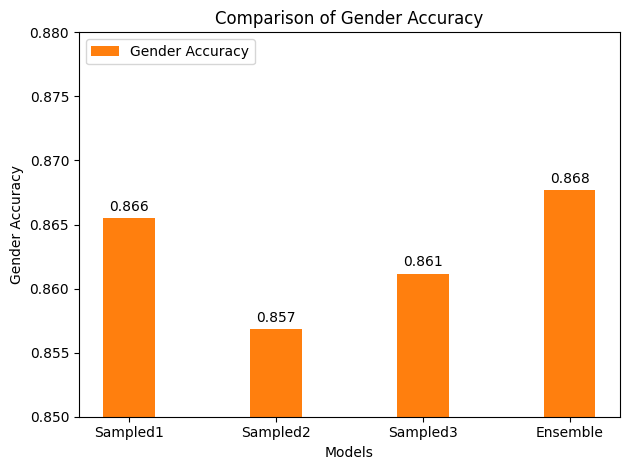

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 설정
models = ['Sampled1', 'Sampled2', 'Sampled3', 'Ensemble']
age_mae = [final_mae1, final_mae2, final_mae3, final_mae]
gender_accuracy = [final_accuracy1, final_accuracy2, final_accuracy3, final_accuracy]

x = np.arange(len(models))  # 모델의 인덱스
width = 0.35  # 막대의 너비

# MAE 그래프
fig, ax1 = plt.subplots()
rects1 = ax1.bar(x, age_mae, width, label='Age MAE', color='tab:blue')

# 그래프에 텍스트 추가
def autolabel(rects, ax, decimal_places=2):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.{decimal_places}f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 포인트 위로 이동
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax1)

# 레이블 및 제목 설정
ax1.set_xlabel('Models')
ax1.set_ylabel('Age MAE')
ax1.set_title('Comparison of Age MAE')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')
ax1.set_ylim(5, 7)

fig.tight_layout()  # 레이아웃 조정
plt.show()

# Accuracy 그래프
fig, ax2 = plt.subplots()
rects2 = ax2.bar(x, gender_accuracy, width, label='Gender Accuracy', color='tab:orange')

autolabel(rects2, ax2, decimal_places=3)

# 레이블 및 제목 설정
ax2.set_xlabel('Models')
ax2.set_ylabel('Gender Accuracy')
ax2.set_title('Comparison of Gender Accuracy')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend(loc='upper left')
ax2.set_ylim(0.85, 0.88)

fig.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
IMAGE_SIZE=224
gender_mapping=['Male','Female']

rand_image_path = np.random.choice(image_path)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_path)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

# Show the image
plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()
# Load the Image
image = tf.io.read_file(dir_path + rand_image_path)
image = tf.io.decode_jpeg(image)
# Resize and Normalize the Image
image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
image = image / 255.
image = tf.cast(image, tf.float32)
image = tf.reshape(image, [-1,224,224,3])
pred_age, pred_gender = bagging_by_average(model1, model2, model3, image)
pred_age = int(np.round(np.squeeze(pred_age)))
pred_gender = int(np.round(pred_gender))
print(pred_age, gender_mapping[pred_gender])

NameError: name 'image_path' is not defined

In [ ]:
IMAGE_SIZE=224

In [ ]:
def bagging_by_average(model1, model2, model3, image):
  pred_age_1, pred_gender_1 = model1.predict(image, verbose=0)
  pred_age_2, pred_gender_2 = model2.predict(image, verbose=0)
  pred_age_3, pred_gender_3 = model3.predict(image, verbose=0)
  print(f'model1 - age : {pred_age_1}, gender : {pred_gender_1}')
  print(f'model2 - age : {pred_age_2}, gender : {pred_gender_2}')
  print(f'model3 - age : {pred_age_3}, gender : {pred_gender_3}')
  # print(f'average - age : {np.mean([pred_age1,pred_age2, pred_age3])}, gender: {np.mean([pred_gender1, pred_gender2, pred_gender3])}')
  pred_age = np.mean([pred_age_1,pred_age_2, pred_age_3])
  pred_gender = np.mean([pred_gender_1, pred_gender_2, pred_gender_3])
  return pred_age, pred_gender

## Test in Webcam

In [ ]:
!pip install mediapipe

In [ ]:
from google.colab import output
from IPython.display import display, Javascript
from ipywidgets import widgets
import cv2
import numpy as np
import mediapipe as mp
import math
import base64

# Mediapipe의 얼굴 검출 모듈 초기화
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# JavaScript를 사용하여 웹캠 영상을 캡처하는 함수
def capture_image():
    js = Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            return canvas.toDataURL('image/jpeg');
        }
        captureImage();
    ''')
    display(js)
    data = output.eval_js('captureImage()')
    return data

# 캡처된 이미지를 디코딩하는 함수
def data_uri_to_image(data_uri):
    header, encoded = data_uri.split(",", 1)
    data = np.frombuffer(base64.b64decode(encoded), dtype=np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return image

# 얼굴 방향 각도 계산 함수
def calculate_yaw_angle(detection):
    landmarks = detection.location_data.relative_keypoints
    left_eye = landmarks[mp_face_detection.FaceKeyPoint.LEFT_EYE]
    right_eye = landmarks[mp_face_detection.FaceKeyPoint.RIGHT_EYE]
    nose = landmarks[mp_face_detection.FaceKeyPoint.NOSE_TIP]
    eye_center_x = (left_eye.x + right_eye.x) / 2
    eye_center_y = (left_eye.y + right_eye.y) / 2
    nose_x = nose.x
    nose_y = nose.y
    angle_rad = math.atan2(eye_center_y - nose_y, eye_center_x - nose_x)
    angle_deg = math.degrees(angle_rad) + 90
    return angle_deg

# Mediapipe 얼굴 검출 모델 초기화
with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5) as face_detection:
    while True:
        data = capture_image()
        image = data_uri_to_image(data)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)
        if results.detections:
            for detection in results.detections:
                angle_deg = calculate_yaw_angle(detection)
                bboxC = detection.location_data.relative_bounding_box
                if bboxC is None:
                    break
                ih, iw, _ = image.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                if x < 0 or y < 0 or w > iw or h > ih:
                    break
                detected_image = image[y:y+h, x:x+w]
                # detected_image = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)
                input_data = tf.image.resize(detected_image, [224,224])
                input_data = tf.reshape(input_data, [-1,224,224,3])
                input_data = input_data/255.0
                pred_age, pred_gender = bagging_by_average(model1, model2, model3, input_data)
                pred_age = int(np.round(np.squeeze(pred_age)))
                pred_gender = int(np.round(pred_gender))
                cv2.putText(image, f"AGE: {pred_age}", (x, y-7),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.putText(image, f"GENDER: {'M' if pred_gender==0 else 'W'}", (x, y-32),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.putText(image, f"Angle: {angle_deg:.2f} °", (x, y - 62), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                mp_drawing.draw_detection(image, detection)
        _, img_encoded = cv2.imencode('.jpg', image)
        img_bytes = img_encoded.tobytes()
        display(widgets.Image(value=img_bytes))

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

model1 - age : [[29.953176]], gender : [[0.98081744]]
model2 - age : [[30.165773]], gender : [[0.54295623]]
model3 - age : [[30.313623]], gender : [[0.9371411]]


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

model1 - age : [[31.498001]], gender : [[0.9998338]]
model2 - age : [[18.22643]], gender : [[0.97000307]]
model3 - age : [[22.39195]], gender : [[0.9998995]]


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

model1 - age : [[22.445072]], gender : [[0.38786995]]
model2 - age : [[19.290792]], gender : [[0.05911375]]
model3 - age : [[27.671404]], gender : [[0.08832282]]


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

model1 - age : [[12.874295]], gender : [[0.46588904]]
model2 - age : [[15.820591]], gender : [[0.03171678]]
model3 - age : [[16.163494]], gender : [[0.1310088]]


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

model1 - age : [[18.48489]], gender : [[0.33275044]]
model2 - age : [[10.521489]], gender : [[0.10568982]]
model3 - age : [[19.42896]], gender : [[0.21758726]]


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

<IPython.core.display.Javascript object>

KeyboardInterrupt: 